In [ ]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)

In [1]:
''' 
No longer possible to compute matrix A given 32 dimension inputs
'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from collections import defaultdict
from line_profiler import profile
from sklearn.model_selection import train_test_split

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.BFmethod as graphing
import src.visualization.Metrics as metrics
import src.visualization.ImagePlots as imgplt
import src.data_processing.ImageProducts as ImageProducts
import src.helpers.ModelUtilities as models

from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


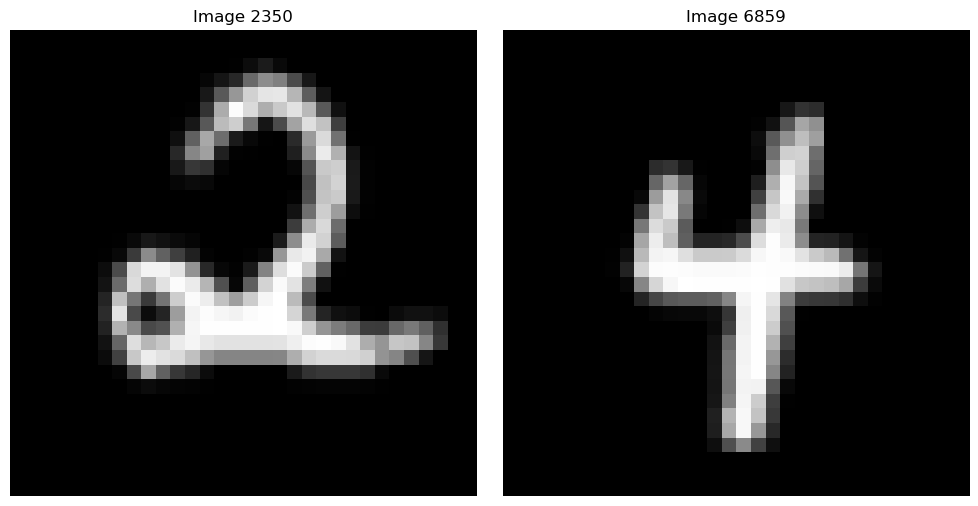

10000


In [2]:
# ----------------------------------Test for unique image----------------------------------
k=5
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
full_dataset = testset
# ----------------------------------Preparing the Dataset----------------------------------
index1 = np.random.randint(len(full_dataset))
index2 = np.random.randint(len(full_dataset))
    
input_dataset = []
for i in range(len(full_dataset)):
    image,label = full_dataset[i]
    img = image.unsqueeze(0).cuda().double()  #1x1xHxW
    input_dataset.append(img)

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).cuda().float() for data in input_dataset]

NCC_dataset = []
for i in range(len(full_dataset)):
    image,label = full_dataset[i]
    image_array = image.numpy()
    NCC_dataset.append(image_array.squeeze()) 
    
input1 = NCC_dataset[index1]
input2 = NCC_dataset[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

print(len(full_dataset))

In [3]:
# -----------------------------Evaluating Results-----------------------------
model = models.CNN().cuda()
model.load_state_dict(torch.load('model/best_model_batch_greyscale_MNIST_circular.pt', weights_only=True))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#----------------------Metric 1 - Loss Calculation-----------------

NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss calculation")
print("\nScaled NCC: ",NCC_scaled_value)

embedded_vector_image1 = model(input_dataset[index1])
embedded_vector_image2 = model(input_dataset[index2])

dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)

print("Dot product value of model: ", dot_product_value.item())

loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", loss_value)


Loss calculation

Scaled NCC:  0.6999330520629883
Dot product value of model:  0.9446732997894287
Loss:  0.24474024772644043



Model Method -- KNN-IOU score for k = 5


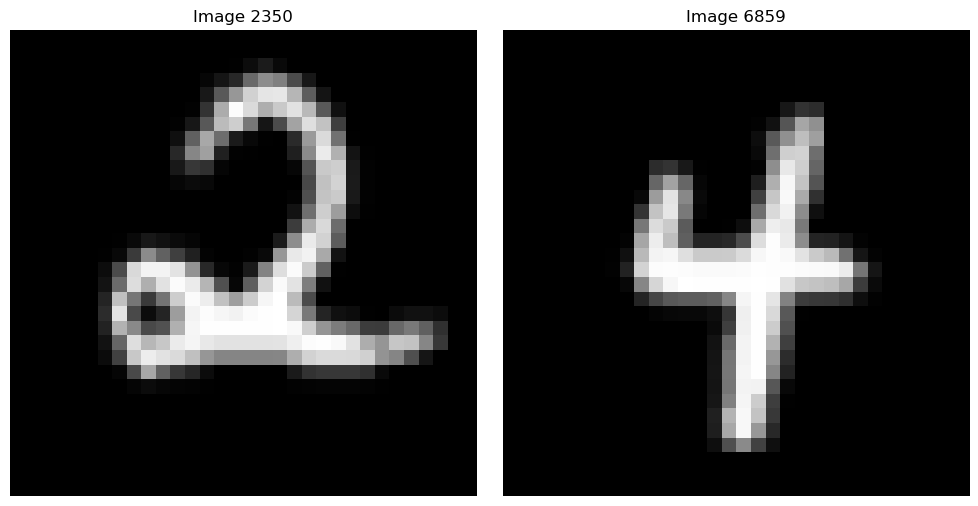

Estimating K-Score for Image 2350: K-Score = 0.09090909090909091
Intersection sets : [2350]
Union sets: [ 516 1930 2350 3355 3913 4506 6279 6337 7281 8161 9635]

Top 11 values of Vector b
Rank 1: Value = 1.0, Index = 2350
Rank 2: Value = 0.9134933948516846, Index = 1930
Rank 3: Value = 0.8815571069717407, Index = 8161
Rank 4: Value = 0.8627177476882935, Index = 3355
Rank 5: Value = 0.8612812757492065, Index = 7281
Rank 6: Value = 0.8444010019302368, Index = 9635
Rank 7: Value = 0.8439645767211914, Index = 516
Rank 8: Value = 0.841278076171875, Index = 2176
Rank 9: Value = 0.8394864797592163, Index = 8612
Rank 10: Value = 0.8378129005432129, Index = 2729
Rank 11: Value = 0.8349965810775757, Index = 208

Top 11 values of Vector c
Rank 1: Value = 0.9999999403953552, Index = 2350
Rank 2: Value = 0.9923083186149597, Index = 6279
Rank 3: Value = 0.9915112853050232, Index = 6337
Rank 4: Value = 0.9907199144363403, Index = 516
Rank 5: Value = 0.9906156063079834, Index = 3913
Rank 6: Value = 0.

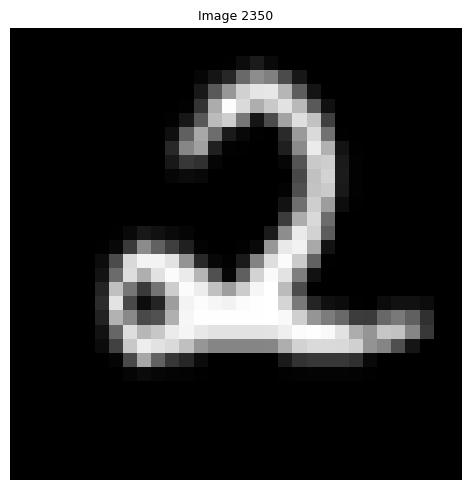


Plotting images in the union set:


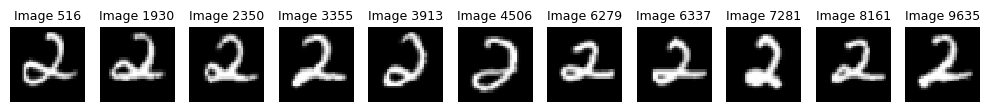


For translationally unique plots: 
Image 516 has no translationally similar images.
Image 1930 has no translationally similar images.
Image 2350 has no translationally similar images.
Image 3355 has no translationally similar images.
Image 3913 has no translationally similar images.
Image 4506 has no translationally similar images.
Image 6279 has no translationally similar images.
Image 6337 has no translationally similar images.
Image 7281 has no translationally similar images.
Image 8161 has no translationally similar images.
Image 9635 has no translationally similar images.

Plotting images in the intersection set:


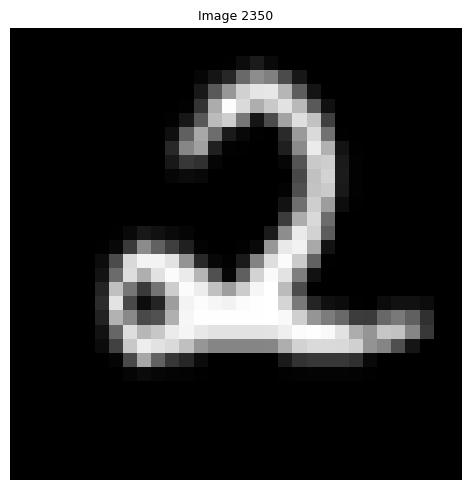


Plotting images in the union set:


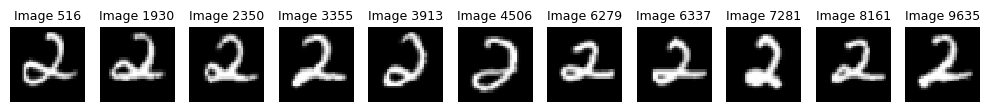

Estimating K-Score for Image 6859: K-Score = 0.3333333333333333
Intersection sets : [5774 6427 6859]
Union sets: [4598 4772 5175 5664 5774 6427 6812 6859 8033]

Top 9 values of Vector b
Rank 1: Value = 1.0, Index = 6859
Rank 2: Value = 0.9462378025054932, Index = 6427
Rank 3: Value = 0.9440053701400757, Index = 8033
Rank 4: Value = 0.935375452041626, Index = 4772
Rank 5: Value = 0.9336092472076416, Index = 5664
Rank 6: Value = 0.9331109523773193, Index = 5774
Rank 7: Value = 0.9217963218688965, Index = 7083
Rank 8: Value = 0.9198520183563232, Index = 6854
Rank 9: Value = 0.9165467023849487, Index = 8829

Top 9 values of Vector c
Rank 1: Value = 1.0, Index = 6859
Rank 2: Value = 0.9980239868164062, Index = 6427
Rank 3: Value = 0.9974948763847351, Index = 4598
Rank 4: Value = 0.9974499344825745, Index = 6812
Rank 5: Value = 0.9969322085380554, Index = 5774
Rank 6: Value = 0.9962601661682129, Index = 5175
Rank 7: Value = 0.9960026741027832, Index = 3700
Rank 8: Value = 0.9959839582443237,

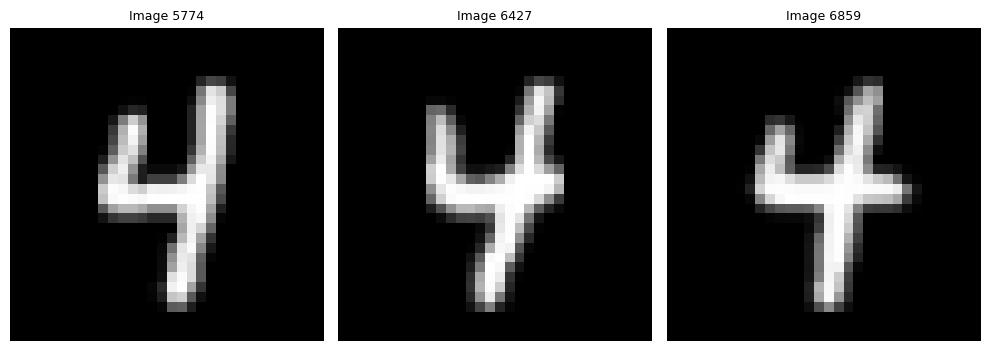


Plotting images in the union set:


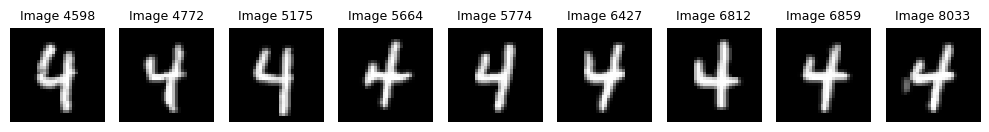


For translationally unique plots: 
Image 4598 has no translationally similar images.
Image 4772 has no translationally similar images.
Image 5175 has no translationally similar images.
Image 5664 has no translationally similar images.
Image 5774 has no translationally similar images.
Image 6427 has no translationally similar images.
Image 6812 has no translationally similar images.
Image 6859 has no translationally similar images.
Image 8033 has no translationally similar images.

Plotting images in the intersection set:


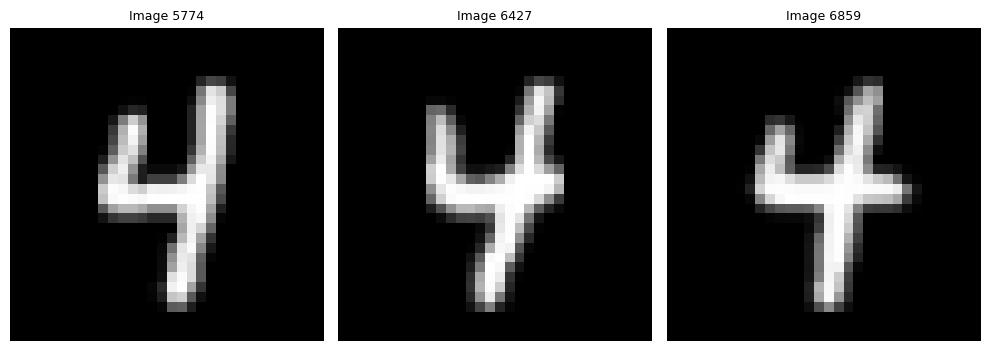


Plotting images in the union set:


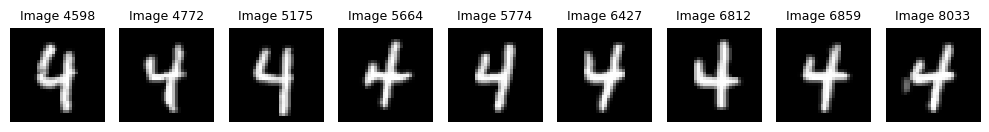

In [4]:
#----------------------Metric 2 - KNNIoU-----------------
print(f"\nModel Method -- KNN-IOU score for k = {k}")

imgplt.plot_original_images(NCC_dataset[index1], NCC_dataset[index2], index1, index2)
vectorb_model1 = imgcalc.get_vectorb_model(index1, model, NCC_dataset)
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, NCC_dataset)
   
vectorb_model2 = imgcalc.get_vectorb_model(index2, model, NCC_dataset)        
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, NCC_dataset)

50

Generating K-Score for index 3305 of label 0
K-Score for index 3305 is 0.0
Average loss for index 3305 is 0.05371298832893372

Generating K-Score for index 4470 of label 0
K-Score for index 4470 is 0.0
Average loss for index 4470 is 0.07432165084779263

Generating K-Score for index 581 of label 0
K-Score for index 581 is 0.0
Average loss for index 581 is 0.07611104182004928

Generating K-Score for index 8576 of label 0
K-Score for index 8576 is 0.0
Average loss for index 8576 is 0.06545309792757034

Generating K-Score for index 6211 of label 0
K-Score for index 6211 is 0.0
Average loss for index 6211 is 0.08905638682544231

Generating K-Score for index 7023 of label 1
K-Score for index 7023 is 0.0
Average loss for index 7023 is 0.07378893456757069

Generating K-Score for index 2366 of label 1
K-Score for index 2366 is 0.0
Average loss for index 2366 is 0.07079370256364345

Generating K-Score for index 4105 of label 1
K-Score for index 4105 is 0.0
Average loss for index 4105 is 0.07

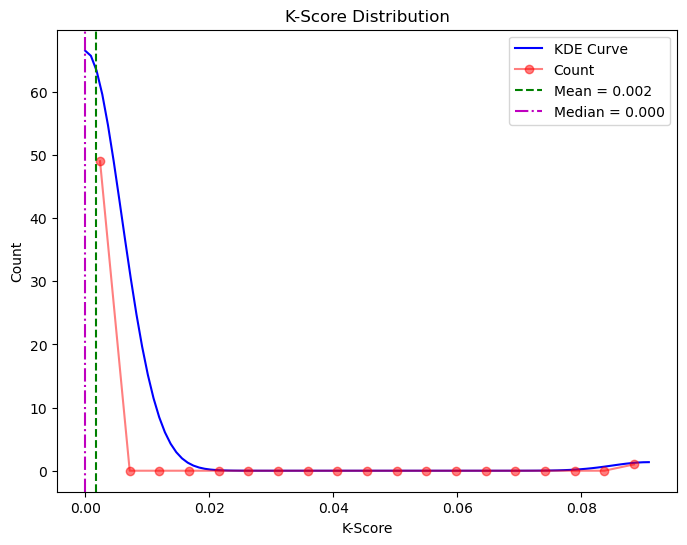

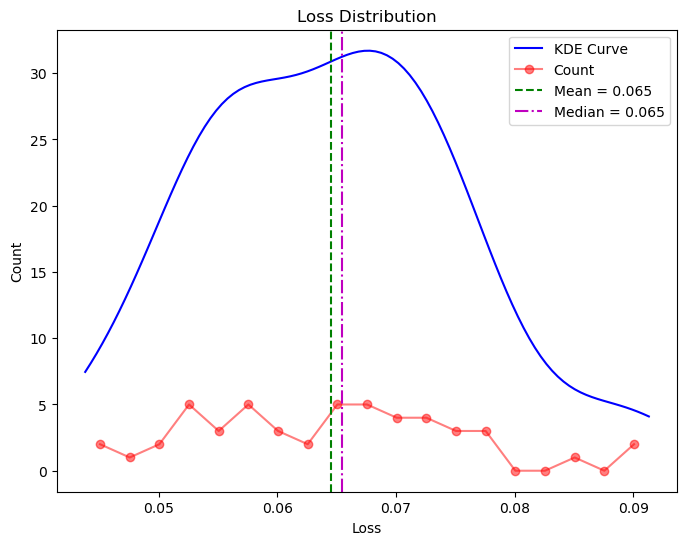

In [7]:
#--------------------Visualisation across subset of test dataset-------------------

#sample 100 image per digit
labels = full_dataset.targets.numpy()
sampled_indices = []
for digit in range(10):
    digit_indices = np.where(labels == digit)[0] 
    sampled = np.random.choice(digit_indices, 5, replace=False)
    sampled_indices.extend(sampled)

print(len(sampled_indices))
kscores = []
losses = []
ncc_intervals = [round(i * 0.1, 1) for i in range(-10, 10)]  # [-1.0, -0.9, ..., 0.9]
ncc_loss_dict = {
    f"{lower:.1f}-{lower + 0.1:.1f}": [] 
    for lower in ncc_intervals
}
epsilon = 1e-8

for i in sampled_indices:
    _, label = full_dataset[i]
    print(f"\nGenerating K-Score for index {i} of label {label}")
    vectorb = imgcalc.get_vectorb_model(i, model, NCC_dataset)
    vectorc = imgcalc.get_vectorc_model(i, model, input_dataset)
    kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc, k)
    kscores.append(kscore)
    print(f"K-Score for index {i} is {kscore}")
    
    loss = []
    
    for j in range(len(NCC_dataset)):
        NCC_scaled_value = imgcalc.get_NCC_score(NCC_dataset[i], NCC_dataset[j])
        embedded_vector_image1 = model(input_dataset[i])
        embedded_vector_image2 = model(input_dataset[j])
        dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)
        loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
        loss.append(loss_value)
        
        lower_bound = math.floor(NCC_scaled_value * 10) / 10
        
        # Handle edge case for values
        if NCC_scaled_value < -1.0:
            lower_bound = -1.0
        elif lower_bound > 0.9 or NCC_scaled_value == 1.0:
            lower_bound = 0.9
        interval_key = f"{lower_bound:.1f}-{lower_bound + 0.1:.1f}"

        ncc_loss_dict[interval_key].append(loss_value)
    
    average_loss = sum(loss) / len(loss)  
    print(f"Average loss for index {i} is {average_loss}")
    losses.append(average_loss)

average_loss_per_interval = {
    interval: sum(values)/len(values) if values else 0
    for interval, values in ncc_loss_dict.items()
}

print("\nNCC Interval\t\tAverage Loss")
for interval in sorted(ncc_loss_dict.keys()):
    avg_loss = average_loss_per_interval[interval]
    count = len(ncc_loss_dict[interval])
    print(f"{interval}\t\t{avg_loss:.4f} ({count} samples)")
    
imgplt.plot_score_distribution(kscores, "K-Score")
imgplt.plot_score_distribution(losses, "Loss")

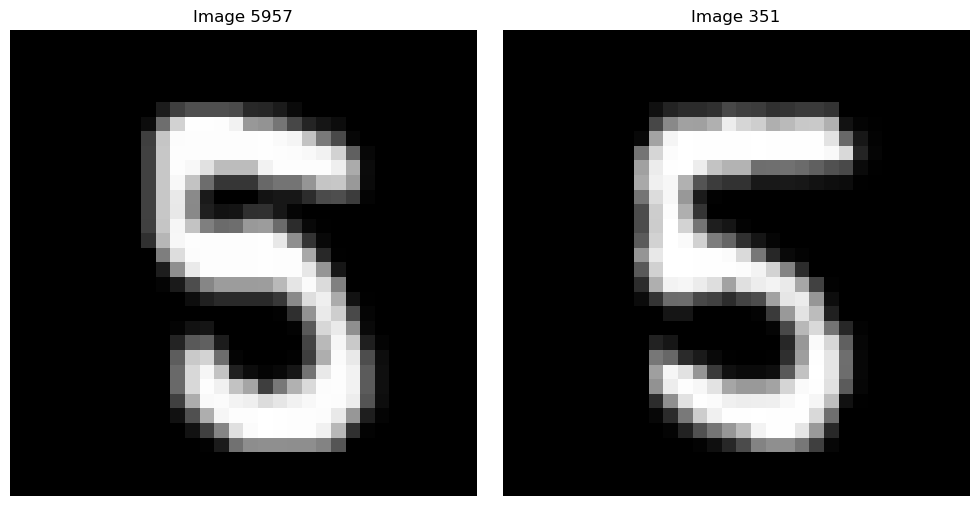


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

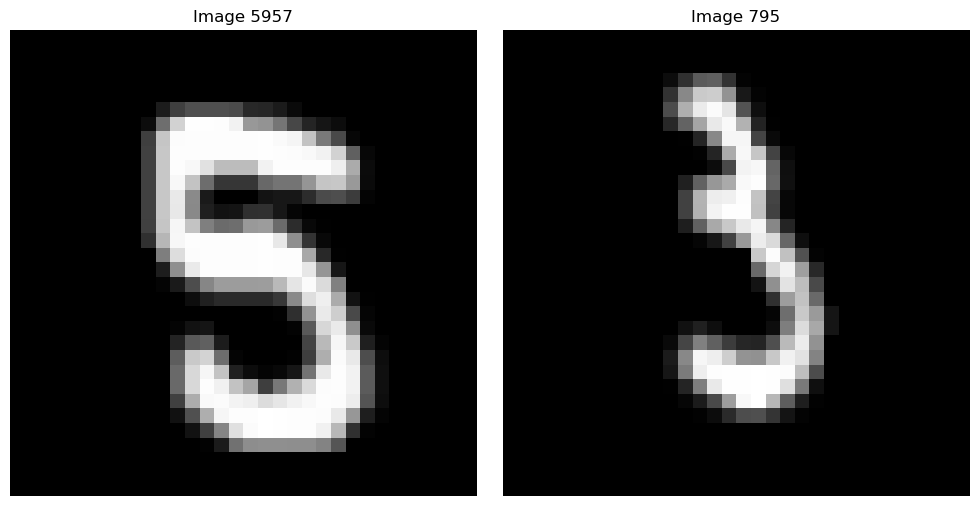


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

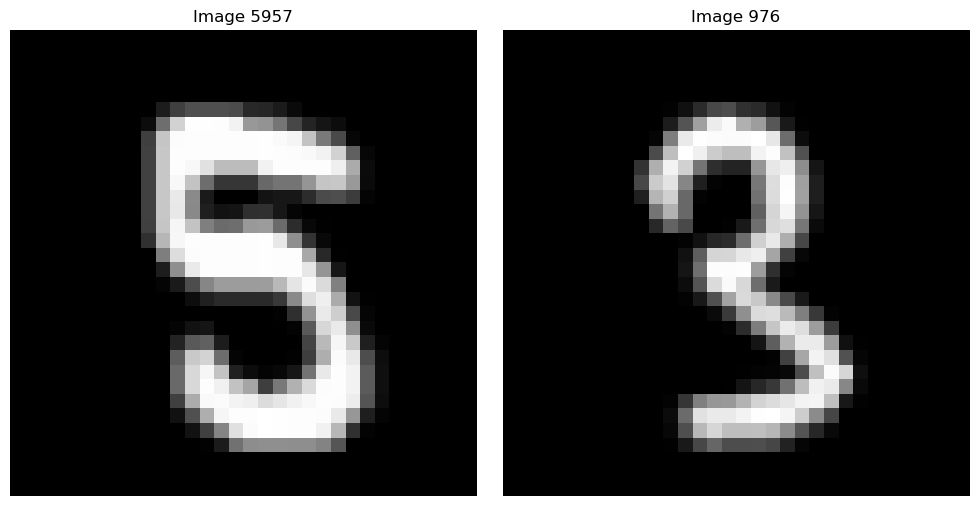


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

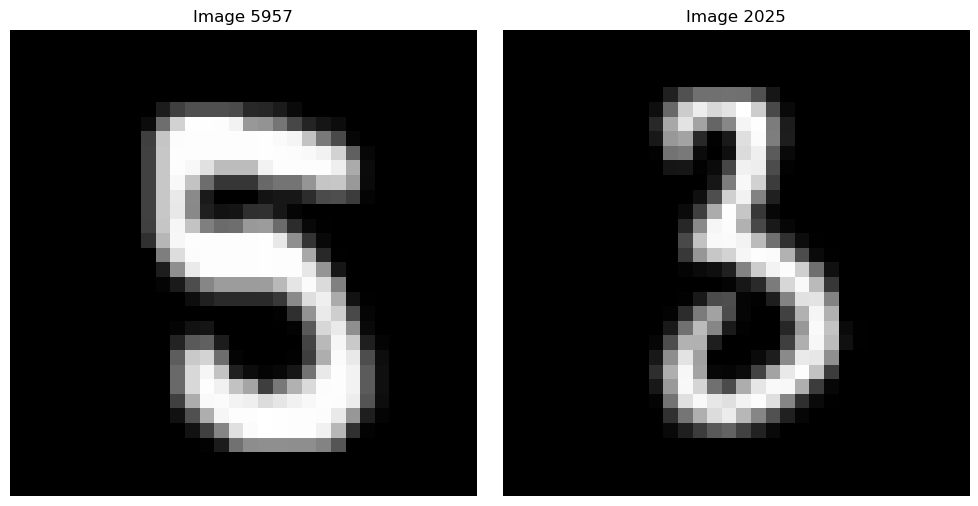


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

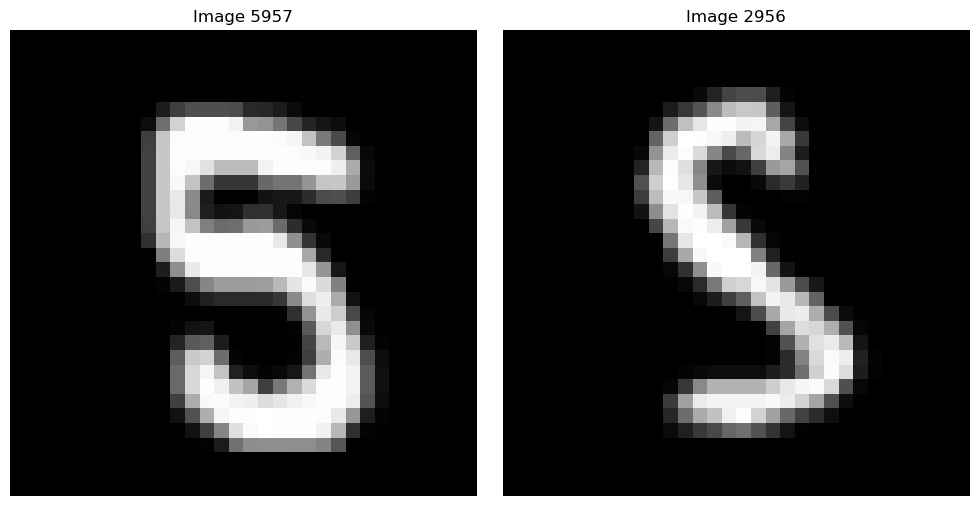


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

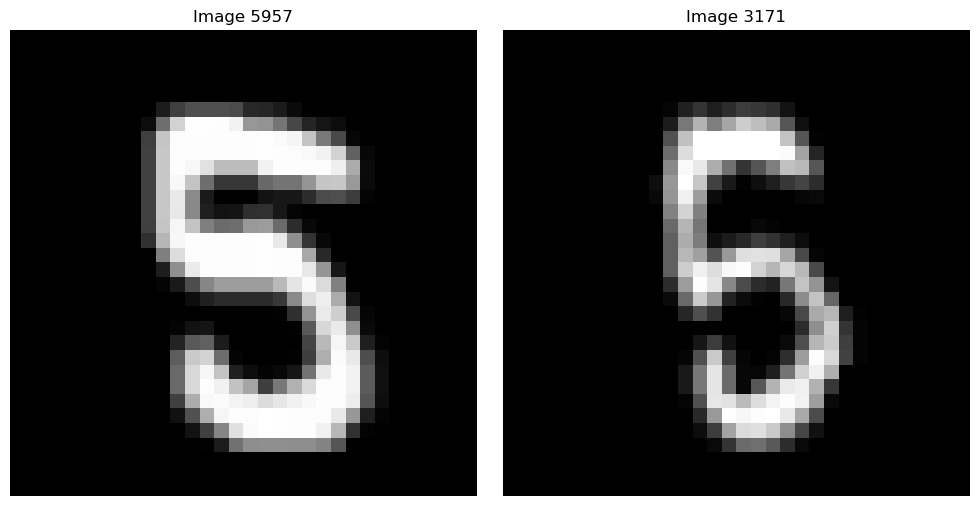


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

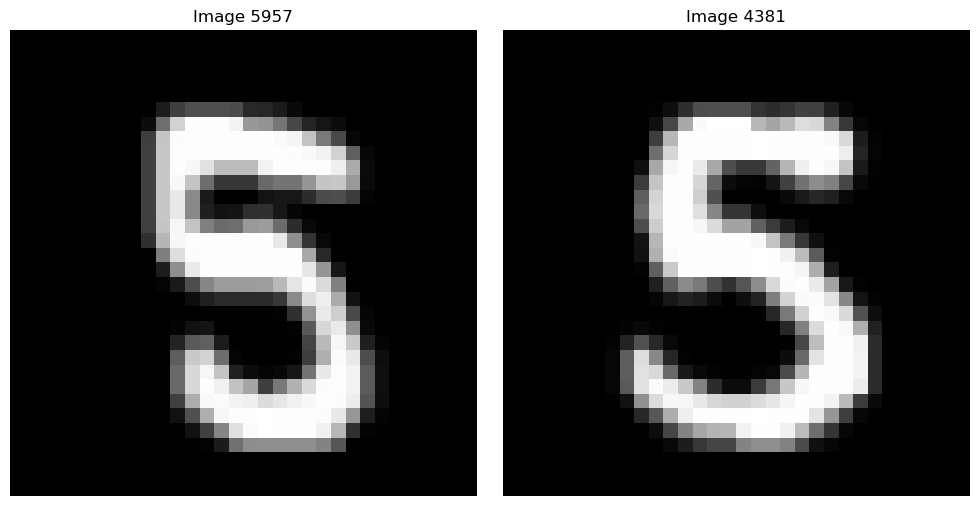


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

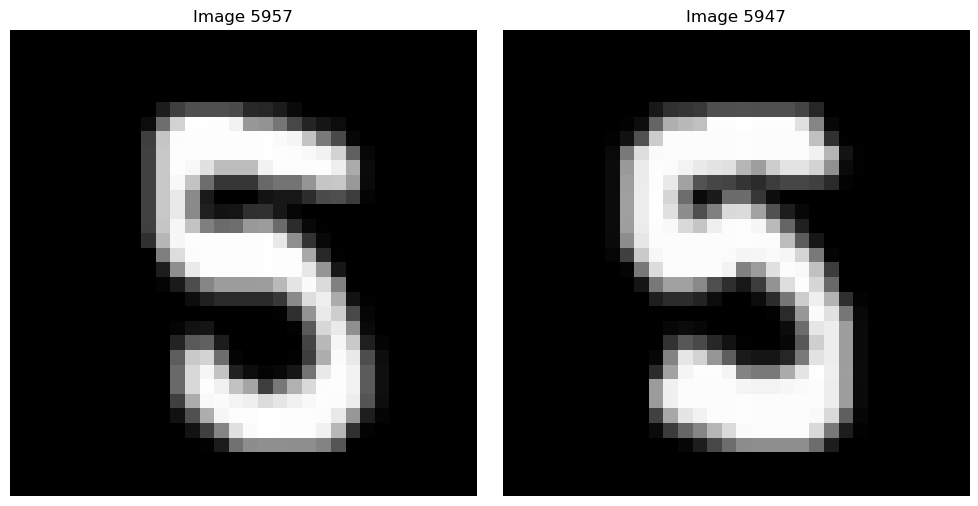


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

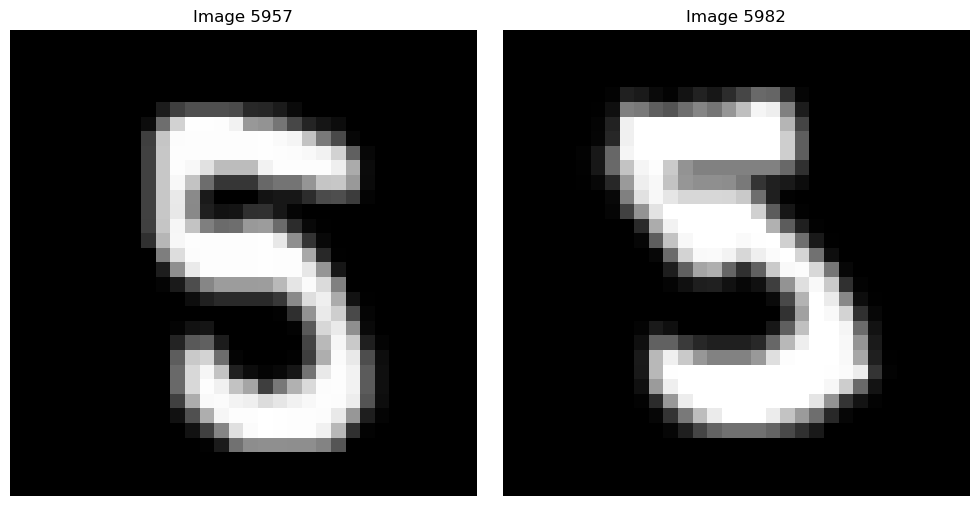


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

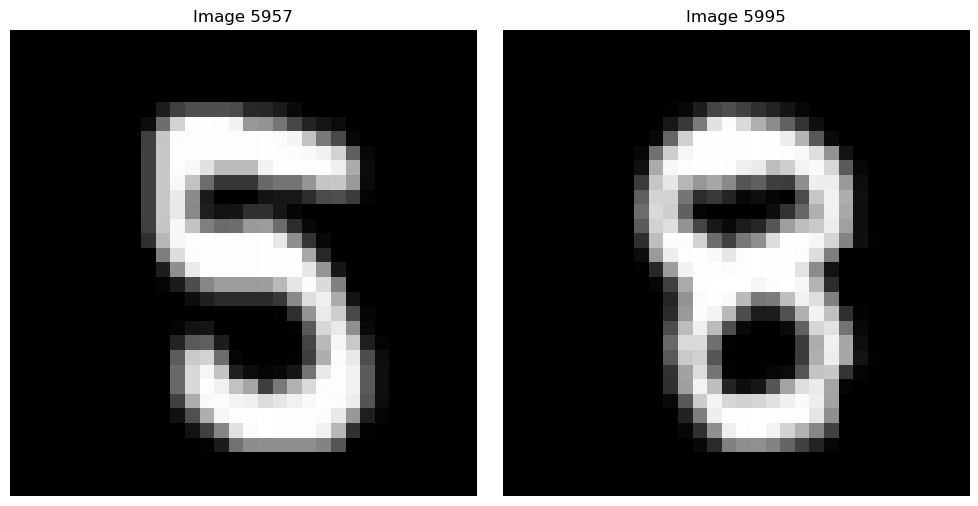


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

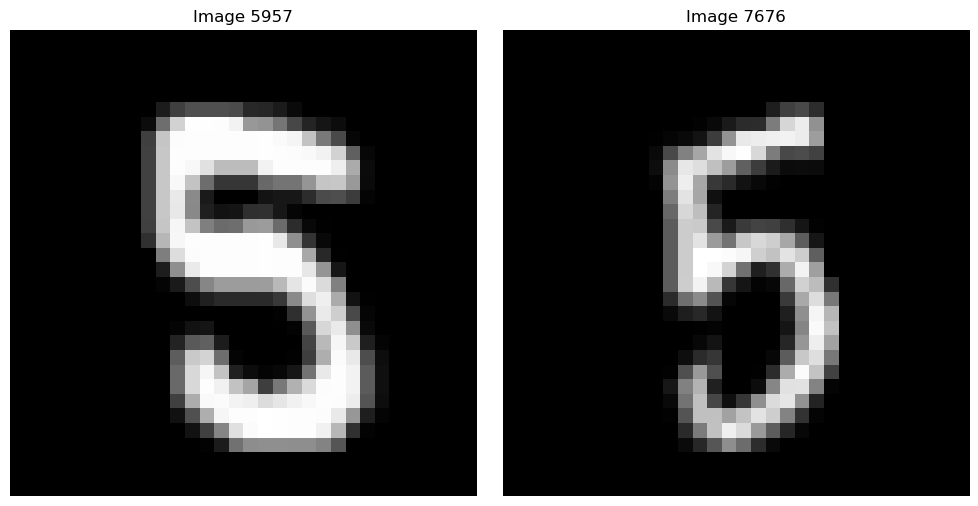


Embedded vector 1:  tensor([[ 2.3512e-04,  7.9354e-03,  2.1269e-01, -1.4747e-02, -4.5247e-02,
          1.6995e-02, -2.0179e-02,  1.9046e-02,  1.2582e-01, -1.1124e-02,
          1.6012e-02,  1.9974e-02,  9.8200e-03,  1.1737e-02,  1.8654e-02,
          2.0707e-01,  3.5254e-02, -1.8866e-03, -1.2475e-02, -2.2623e-02,
          2.3007e-02,  4.9827e-03, -1.2618e-02,  1.3927e-01,  2.8959e-02,
         -8.2263e-03,  1.5490e-02, -3.3955e-02, -8.9568e-03,  4.7915e-03,
         -6.3117e-03,  9.2987e-03,  2.5071e-02,  6.0883e-02, -1.4819e-02,
          7.9082e-03, -3.9634e-03,  6.6747e-02,  3.3290e-02, -1.8867e-01,
          3.8084e-02,  2.8462e-02,  1.8608e-01,  1.1232e-02, -7.8036e-03,
         -2.6432e-02,  4.4506e-02,  1.3926e-02,  9.6266e-03,  1.7301e-01,
          9.6317e-03, -2.7143e-02, -1.6005e-02, -1.4592e-01,  1.0345e-01,
         -4.2610e-02, -2.2753e-01, -4.0342e-02, -6.0939e-03, -4.0072e-02,
          2.2852e-02, -3.0991e-02,  7.9492e-03,  1.4302e-01, -1.7762e-03,
         -1.2795e

In [5]:
# --------------------- Test embeddings of similar images --------------------
kscore, indices, intersection_indices = imgcalc.get_kscore_and_sets(vectorb_model1, vectorc_model1, k)

for idx in indices:
    if idx == index1:
        continue
    embedded_vector_image1 = model(input_dataset[index1])
    embedded_vector_image2 = model(input_dataset[idx])
    imgplt.plot_original_images(NCC_dataset[index1], NCC_dataset[idx], index1, idx)
    print("\nEmbedded vector 1: ", embedded_vector_image1)
    print("Embedded vector 2: ", embedded_vector_image2)
    print("Vector Differences: ", embedded_vector_image1-embedded_vector_image2)
    print("Average differences: ", (abs(embedded_vector_image1-embedded_vector_image2).detach().cpu().numpy().sum())/128)    

In [5]:
# --------------------- Test LPS layer && Test translationally similar images --------------------
model = models.CNN().cuda()
model.load_state_dict(torch.load('model/best_model_batch_greyscale_MNIST_circular.pt', weights_only=True))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ----------------------------------Preparing the Dataset----------------------------------
augmentation_transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.RandomAffine(
        degrees=0,  # No rotation
        translate=(0.1, 0.1),  # Random horizontal/vertical shifts (10% of image size)
        fill=0,  # Pad with black (MNIST background)
        interpolation=transforms.InterpolationMode.NEAREST
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmented_testset = torchvision.datasets.MNIST(root='./data', train=False, transform=augmentation_transform)


input_dataset_augmented = []
for i in range(len(augmented_testset)):
    image,label = augmented_testset[i]
    img = image.unsqueeze(0).cuda().double()  #1x1xHxW
    input_dataset_augmented.append(img)

stacked_tensor = torch.stack(input_dataset_augmented)
input_dataset_augmented = stacked_tensor.cpu().numpy()      
input_dataset_augmented = [torch.tensor(data).cuda().float() for data in input_dataset_augmented]

NCC_dataset_augmented = []
for i in range(len(augmented_testset)):
    image,label = augmented_testset[i]
    image_array = image.numpy()
    NCC_dataset_augmented.append(image_array.squeeze()) 
    
input1 = NCC_dataset[index1]
input2 = NCC_dataset_augmented[index1]

# np.savez('data.npz', input1=input1, input2=input2) 9 9

imgplt.plot_original_images(input1, input2, index1, index1)

print("Are they unique of each other: ", imgcalc.check_translationally_unique(input1,input2))

NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss calculation")
print("\nScaled NCC: ",NCC_scaled_value)

embedded_vector_image1 = model(input_dataset[index1])
embedded_vector_image2 = model(input_dataset_augmented[index1])

dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)

print("Dot product value of model: ", dot_product_value.item())

loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", loss_value)

print("Embedded vector 1: ", embedded_vector_image1)
print("Embedded vector 2: ", embedded_vector_image2)
print("Vector Differences: ", embedded_vector_image1-embedded_vector_image2)
print("Average differences: ", (abs(embedded_vector_image1-embedded_vector_image2).detach().cpu().numpy().sum())/128)

def is_unit_vector(vector, tol=1e-6):
    norm = torch.norm(vector)  
    print(norm)
    return torch.isclose(norm, torch.tensor(1.0), atol=tol)  

# Example usage
vec = embedded_vector_image1  
print(is_unit_vector(vec))  # True


KeyboardInterrupt



In [7]:
input1_loaded = NCC_dataset[index1]
input2_loaded = NCC_dataset_augmented[index1]

print(input1_loaded.shape)
#img = torch.from_numpy(np.array(Image.open('butterfly.png'))).permute(2,0,1)
img = torch.from_numpy(input1_loaded)

img = img.unsqueeze(0).unsqueeze(0).cuda()
print("img shape: ", img.shape)

#gives identical embedding
#img_roll = torch.roll(img,shifts=(1, 1), dims=(-1, -2)) 

img_roll = torch.from_numpy(input2_loaded)
img_roll = img_roll.unsqueeze(0).unsqueeze(0).cuda()

print(img_roll.shape)

y_orig = model(img).detach().cpu()
y_roll = model(img_roll).detach().cpu()

# outputs logits before classification
print(y_orig)

print( y_roll)

(32, 32)
img shape:  torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])
tensor([[-0.0443, -0.0448,  0.0382,  0.0081,  0.0613, -0.1344, -0.0084, -0.0506,
         -0.1258, -0.0446,  0.0643, -0.0906, -0.0826, -0.0828, -0.1448, -0.0379,
         -0.0623,  0.0267,  0.0868, -0.0393, -0.0688,  0.0408,  0.0721,  0.0356,
          0.0490,  0.0181,  0.0732, -0.0401,  0.0079, -0.0479, -0.0707, -0.1349,
         -0.0698, -0.0318,  0.0622, -0.0911,  0.0428, -0.0536, -0.0841,  0.0591,
          0.0251,  0.0555,  0.0047,  0.0195, -0.0381,  0.0268,  0.0149,  0.0584,
         -0.0476, -0.0739, -0.0872,  0.0136,  0.0648,  0.1146, -0.0070,  0.0805,
         -0.0558, -0.0466,  0.0066,  0.0716,  0.0396, -0.0691,  0.0483,  0.1190,
          0.0758, -0.0004,  0.0580,  0.0107, -0.0126, -0.1064,  0.0664, -0.0497,
          0.0775,  0.0499,  0.0290, -0.0879,  0.1320, -0.0604,  0.0475,  0.0411,
         -0.0635, -0.0600, -0.0603, -0.0489,  0.0216, -0.0711, -0.0909, -0.0065,
          0.1224,  0.0681, -0.0320

In [ ]:
#--------------------
def visualize_filters(model, layer_name):
    layer = dict(model.named_modules())[layer_name]
    if isinstance(layer, torch.nn.Conv2d):
        filters = layer.weight.data.cpu().numpy()

        num_filters = filters.shape[0]  # Number of filters
        fig, axes = plt.subplots(1, min(num_filters, 8), figsize=(10, 5))

        for i in range(min(num_filters, 8)):  # Show up to 8 filters
            ax = axes[i]
            ax.imshow(filters[i, 0, :, :], cmap="gray")  # Visualize first channel of filter
            ax.axis("off")
            ax.set_title(f"Filter {i+1}")

        plt.show()
    else:
        print(f"Layer '{layer_name}' is not a Conv2d layer.")

visualize_filters(model, "conv1")